# Generate Samples

In [366]:
from sklearn.datasets import make_blobs, make_moons
# generate 2d classification dataset|
X, y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=1)
# summarize
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

(200, 2) (200,)
[[-10.8278844   -4.83392615]
 [-11.18003063  -4.61910307]
 [-10.55520723  -3.0141798 ]
 [ -1.42706535   5.08904128]
 [ -8.16299488  -3.38896569]]
[1 1 1 0 1]


In [345]:
X, y = make_moons(n_samples=200, noise = 0.2, random_state=1)
# summarize
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

(200, 2) (200,)
[[-0.43319797  0.72526236]
 [ 0.63823632  2.17225336]
 [ 0.52054994  1.21272234]
 [-0.45323519 -0.10879879]
 [ 1.34447155  0.47756744]]
[0 0 0 1 1]


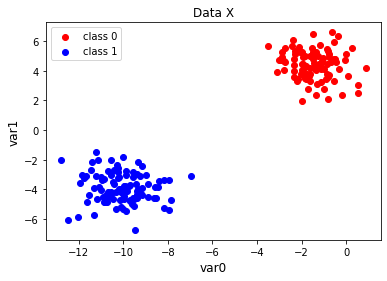

In [367]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(X[y == 0, 0], X[y == 0, 1], c = 'red', label='class 0')
ax.scatter(X[y == 1, 0], X[y == 1, 1], c = 'blue', label='class 1')
ax.set_title('Data X')
ax.set_xlabel('var0', fontsize=12)
ax.set_ylabel('var1', fontsize=12)
ax.legend()

# Naive Bayes Classifier 

In [368]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import numpy as np
import pandas as pd

class NaiveBayesClassifier:
    def __init__(self, smoothing_alpha = 0.01, kernel = None, bandwidth = 2.):
        if not isinstance(smoothing_alpha, float):
            raise TypeError('smoothing_alpha should have float type.')
        if not isinstance(kernel, str) and kernel != None:
            raise TypeError('kernel should have str type.')
        if not isinstance(bandwidth, float):
            raise TypeError('bandwidth should have float type.')
            
        assert smoothing_alpha > 0., 'smoothing_alpha should be higher than 0.'
        assert kernel in [None, 'gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'], "kernel should be None or one of 'gaussian'|'tophat'|'epanechnikov'|'exponential'|linear'|'cosine'"
        assert bandwidth > 0., 'bandwidth should be higher than 0.'
            
        self.__classes_priory = []
        self.__features_info = {}
        self.__smoothing_alpha = smoothing_alpha
        self.__kernel = kernel
        self.__bandwidth = bandwidth

    def fit(self, X, y):
        self.__check_dataframe(X, 'X_train')
        self.__check_dataframe(y, 'y_train')
        
        self.__data_len = len(y)
        self.__classes = np.sort(np.unique(y))
        self.__num_classes = len(self.__classes)
        self.__categorical_threshold = round(np.sqrt(self.__data_len * 0.5)) # empirical formula
        
        self.__set_classes_priory(y)
        
        for feat in X.columns:
            self.__set_feature_info(feat, X[feat].values, np.squeeze(y.values))
        
    
    def __set_classes_priory(self, y):
        for cl in self.__classes:
            self.__classes_priory.append(np.sum(y.values == cl) / self.__data_len)
            
    
    def __set_feature_info(self, feature_name, feature_col, target_col):
        self.__features_info[feature_name] = {}
        feat_type = ''
        feat_unique_count = len(np.unique(feature_col))
        
        if feat_unique_count < self.__categorical_threshold :
            feat_type = 'discrete'
            self.__features_info[feature_name]['categories_proba'] = {}
            self.__features_info[feature_name]['num_categories'] = feat_unique_count
            
            for category in np.sort(np.unique(feature_col)):
                self.__features_info[feature_name]['categories_proba'][category] = []
                
                for cl in self.__classes:
                    self.__features_info[feature_name]['categories_proba'][category].append(
                        self.__get_category_proba_for_class(feature_col[target_col == cl], category, feat_unique_count))
        else:
            feat_type = 'continuous'
            self.__features_info[feature_name]['dist'] = []
            
            for cl in self.__classes:
                self.__features_info[feature_name]['dist'].append(
                    self.__get_continuous_feature_parameters(feature_col[target_col == cl]))
            
        self.__features_info[feature_name]['type'] = feat_type
        
    
    def __get_category_proba_for_class(self, class_feature_col, category, feat_unique_count):
        numerator = np.sum(class_feature_col == category) + self.__smoothing_alpha
        #---------  ----------------------------------------------------------
        denominator = class_feature_col.shape[0] + feat_unique_count * self.__smoothing_alpha
        
        smoothed_proba = numerator/denominator
        return smoothed_proba
        

    def __get_continuous_feature_parameters(self, class_feature_col):
        if self.__kernel:
            dist = KernelDensity(bandwidth=self.__bandwidth, kernel=self.__kernel)
            dist.fit(class_feature_col.reshape(len(class_feature_col), 1))
        else:
            mu = np.mean(class_feature_col)
            sigma = np.std(class_feature_col)
            dist = norm(mu, sigma)
        return dist
        
    
    def predict(self, data):
        self.__check_dataframe(data, 'dataset')
        return data.apply(lambda row: self.__get_single_prediction(row, 'class'), axis = 1).to_numpy()

    
    def predict_proba(self, data, normalize = True):
        self.__check_dataframe(data, 'dataset')
        predictions = np.matrix(data.apply(lambda row: self.__get_single_prediction(row, 'proba'), axis = 1).tolist())
        
        if normalize:
            return np.apply_along_axis(self.__normalize_proba, 1, predictions)
        
        return predictions
    
    
    def __normalize_proba(self, pred):
        pred_sum = np.sum(pred)
        
        for i in range(len(pred)):
            pred[i] /= pred_sum
        
        return pred
    
    
    def predict_log(self, data):
        self.__check_dataframe(data, 'dataset')
        return np.matrix(data.apply(lambda row: self.__get_single_prediction(row, 'log'), axis = 1).tolist())
        
    
    def __get_single_prediction(self, example, pred_type = 'proba'):
        results = []
        for i in range(len(self.__classes)):
            if pred_type == 'log':
                results.append(np.log(self.__classes_priory[i]))
            else:
                results.append(self.__classes_priory[i])
            
            for key, value in self.__features_info.items():
                feature_proba = 0
                
                if value['type'] == 'discrete':
                    feature_proba = value['categories_proba'][example[key]][i]
                elif value['type'] == 'continuous':
                    if self.__kernel:
                        feature_proba = np.exp(value['dist'][i].score_samples(np.float64(example[key]).reshape(1, -1))[0])
                    else:
                        feature_proba = value['dist'][i].pdf(example[key])
                
                if pred_type == 'log':
                    results[i] += np.log(feature_proba)
                else:
                    results[i] *= feature_proba
                
        if pred_type == 'class':
            return np.argmax(results)
        
        return results
    
    
    def get_params(self):
        return {'data_len': self.__data_len,
                'classes_priory': self.__classes_priory, 
                'smoothing_alpha': self.__smoothing_alpha, 
                'kernel': self.__kernel, 
                'bandwidth': self.__bandwidth, 
                'categorical_threshold': self.__categorical_threshold,
                'features_info': self.__features_info}
    
    
    def __check_dataframe(self, df, df_name):
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"{df_name} should have type pd.DataFrame.")
            
        assert not df.isnull().values.any(), f"{df_name} should not contain NaN values."
        
        for column in df.columns:
            assert not pd.api.types.infer_dtype(df[column]).startswith('mixed'), f"Column '{column}' of {df_name} should not contain mixed type of values."
        
        

In [369]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import numpy as np
import pandas as pd

class BayesClassifier:
    def __init__(self, descr_is_linear = False):
        if not isinstance(descr_is_linear, bool):
            raise TypeError('is_linear should have float boolean.')
        
        self.__classes_info = {}
        self.__descr_is_linear = descr_is_linear

    def fit(self, X, y):
        self.__check_dataframe(X, 'X_train')
        self.__check_dataframe(y, 'y_train', True)
        self.__data_len = len(y)
        self.__classes = np.sort(np.unique(y))
        self.__num_classes = len(self.__classes)
        
        for cl in self.__classes:
            self.__classes_info[cl] = {}
            self.__classes_info[cl]['size'] = sum(y.values == cl)
            self.__classes_info[cl]['priory'] = self.__classes_info[cl]['size'] / self.__data_len
            self.__classes_info[cl]['mean'] = np.mean(X[y.values == cl].values, axis = 0)
            
            if not self.__descr_is_linear:
                subtraction = X[y.values == cl].values - self.__classes_info[cl]['mean']
                dot = np.apply_along_axis(lambda row: np.dot(row[np.newaxis].T, row[np.newaxis]), axis = 1, arr=subtraction)
                self.__classes_info[cl]['covariation_matrix'] = np.mean(dot, axis = 0)
            
        if self.__descr_is_linear:
            means = np.zeros((self.__data_len, len(X.columns)))
            
            for i in range(self.__data_len):
                means[i:] = self.__classes_info[y.iloc[i, 0]]['mean']
            
            subtraction = X.values - means
            dot = np.apply_along_axis(lambda row: np.dot(row[np.newaxis].T, row[np.newaxis]), axis = 1, arr=subtraction)
            self.__classes_info['covariation_matrix'] = np.mean(dot, axis = 0)
    
    
    def predict(self, data):
        self.__check_dataframe(data, 'dataset')
        return data.apply(lambda row: self.__get_single_prediction(row.to_numpy()), axis = 1).to_numpy()
    
    
    def __get_single_prediction(self, example):
        results = []
        
        if self.__descr_is_linear:
            inv_cov = np.linalg.inv(self.__classes_info['covariation_matrix'])
            
        for cl in self.__classes:
            if not self.__descr_is_linear:
                diff = example - self.__classes_info[cl]['mean']
                inv_cov = np.linalg.inv(self.__classes_info[cl]['covariation_matrix'])
                
                first_part = np.squeeze(np.dot(np.dot(diff[np.newaxis], inv_cov), diff[np.newaxis].T)) / 2
                second_part = np.log(np.linalg.det(self.__classes_info[cl]['covariation_matrix'])) / 2
                results.append(np.log(self.__classes_info[cl]['priory']) - first_part - second_part)
            else:
                mult = np.squeeze(np.dot(inv_cov, self.__classes_info[cl]['mean'][np.newaxis].T))
                first_part = np.squeeze(np.dot(self.__classes_info[cl]['mean'][np.newaxis], mult)) / 2
                second_part = np.dot(example, mult)
                results.append(np.log(self.__classes_info[cl]['priory']) - first_part + second_part)
                      
        return np.argmax(results)
    
    
    def get_params(self):
        return {'data_len': self.__data_len,
                'classes_priory': self.__classes_priory, 
                'smoothing_alpha': self.__smoothing_alpha, 
                'kernel': self.__kernel, 
                'bandwidth': self.__bandwidth, 
                'categorical_threshold': self.__categorical_threshold,
                'features_info': self.__features_info}
    
    
    def __check_dataframe(self, df, df_name, is_target=False):
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"{df_name} should have type pd.DataFrame.")
            
        assert not df.isnull().values.any(), f"{df_name} should not contain NaN values."
        
        for column in df.columns:
            if not is_target:
                assert df[column].dtype == np.float or df[column].dtype == np.int, f"Column '{column}' of {df_name} should have type np.int or np.float."
                
            assert not pd.api.types.infer_dtype(df[column]).startswith('mixed'), f"Column '{column}' of {df_name} should not contain mixed type of values."
            
        
        

In [370]:
np.random.seed(1)
data_X = pd.DataFrame(X, columns=['var1', 'var2'])
data_y = pd.DataFrame(y, columns=['training_class'])

In [371]:
classifier = BayesClassifier(False)
classifier.fit(data_X, data_y)
classifier.predict(data_X)

array([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0])

In [372]:
nb_classifier = NaiveBayesClassifier()
nb_classifier.fit(data_X, data_y)
nb_classifier.predict(data_X)

array([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0])

In [373]:
np.squeeze(data_y.values)

array([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0])

In [374]:
print(f"NB classifier : {np.sum(np.abs(nb_classifier.predict(data_X) - np.squeeze(data_y.values)))}")
print(f"Normal classifier : {np.sum(np.abs(classifier.predict(data_X) - np.squeeze(data_y.values)))}")

NB classifier : 0
Normal classifier : 0


# Experiments
## Irises

In [302]:
from sklearn import datasets

In [303]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [304]:
data_X = pd.DataFrame(X, columns=['sepal_length', 'sepal_width', 'pental_length', 'pental_width'])
data_y = pd.DataFrame(y, columns=['training_class'])

Text(0, 0.5, 'Sepal width')

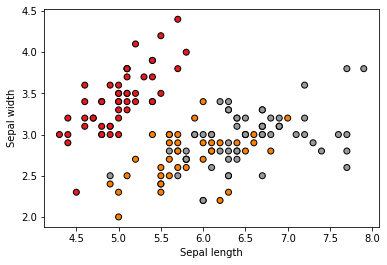

In [305]:
# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

In [311]:
classifier = NaiveBayesClassifier()
classifier.fit(data_X, data_y)

In [312]:
print(y)
pred = classifier.predict(data_X)
print(pred)

num_false_preds = 0
for i in range(len(y)):
    if y[i] != pred[i]:
        num_false_preds += 1
        
print(num_false_preds)
print(len(y))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
6
150


In [313]:
144/150

0.96

In [314]:
classifier.get_params()

{'data_len': 150,
 'classes_priory': [0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333],
 'smoothing_alpha': 0.01,
 'kernel': None,
 'bandwidth': 2.0,
 'categorical_threshold': 9.0,
 'features_info': {'sepal_length': {'dist': [<scipy.stats._distn_infrastructure.rv_frozen at 0x7f79452312d0>,
   'type': 'continuous'},
  'sepal_width': {'dist': [<scipy.stats._distn_infrastructure.rv_frozen at 0x7f7945231190>,
   'type': 'continuous'},
  'pental_length': {'dist': [<scipy.stats._distn_infrastructure.rv_frozen at 0x7f7945221f90>,
   'type': 'continuous'},
  'pental_width': {'dist': [<scipy.stats._distn_infrastructure.rv_frozen at 0x7f794527de90>,
   'type': 'continuous'}}}

## Titanic

In [17]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [426]:
train_data_y = train[['Survived']]
train_data_X = train[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]

test_data_X = test[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]

In [335]:
# with pd.option_context("display.max_rows", train_data_X.shape[0]):
#     display(train_data_X)

In [336]:
sum(train_data_X['Fare'].isnull())

0

In [430]:
train_data_X['Age'].fillna(train_data_X['Age'].mean(), inplace=True)
train_data_X['Embarked'].fillna('S', inplace=True) # most frequent

c:\users\ivan_hladkyi\appdata\local\programs\python\python37\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [431]:
test_data_X['Age'].fillna(test_data_X['Age'].mean(), inplace=True)
test_data_X['Fare'].fillna(test_data_X['Fare'].mean(), inplace=True)
test_data_X['Embarked'].fillna('S', inplace=True) # most frequent

In [356]:
classifier = NaiveBayesClassifier(kernel='linear')
classifier.fit(train_data_X, train_data_y)

In [357]:
y = train_data_y.values.squeeze()
pred = classifier.predict(train_data_X)

num_false_preds = 0
for i in range(len(y)):
    if y[i] != pred[i]:
        num_false_preds += 1
        
print(num_false_preds)
print(len(y))

172
891


In [359]:
(891 - 172) / 891

0.8069584736251403

In [365]:
pred_test = classifier.predict(test_data_X)
test_data_y = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived' : pred_test})

In [367]:
test_data_y.to_csv('predictions.csv')

In [369]:
type(data_X)

pandas.core.frame.DataFrame

In [433]:
train_data_y.iloc[0,:] = 'hi'

c:\users\ivan_hladkyi\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [436]:
pd.api.types.infer_dtype(train_data_y['Survived'])

'mixed-integer'